In [28]:
import statsmodels.formula.api as smf
import sklearn
import sklearn.tree
import sklearn.ensemble
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [29]:
df=pd.read_csv('data/dev/dev-clean-whisper-large-v2-hypotheses.csv')
test_df=pd.read_csv('data/test/test-clean-whisper-large-v2-hypotheses.csv')
df.head()

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78


Notice how imbalanced the dataset is: there are far more hits than insertions or substitutions.

In [30]:
df.shape

(55242, 10)

In [31]:
df['edit_type'].value_counts(), len(df), df['edit_type'].value_counts()/len(df)

(edit_type
 0.0    53708
 1.0      886
 3.0      648
 Name: count, dtype: int64,
 55242,
 edit_type
 0.0    0.972231
 1.0    0.016039
 3.0    0.011730
 Name: count, dtype: float64)

# Data preprocessing
- Represent Part of Speech as one-hot column
- Add feature for word length
- Add feature for word==next/prev_word
- Add Zipf frequencies for start/end of sentence tokens.

There are three "Part of Speech" columns: `word_pos` (for the current word), `prev_word_pos` and `next_word_pos`.
Generate list of all unique parts of speech from across all three columns.

In [32]:
all_pos = set()
pos_cols = [col for col in df.columns if col.endswith('pos')]
for col in pos_cols:
    all_pos.update(df[col].unique())
    all_pos.update(test_df[col].unique())
all_pos = list(all_pos)+['<s>', '</s>']
all_pos.sort()

all_pos

['$',
 '.',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

To use Part of Speech as a feature for training, we need to represent it numerically in some way, since it's a categorical variable. Let's create a one-hot encoding by making a separate column for each part of speech.

In [33]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_df.columns.tolist()
df=pd.concat([df, pos_onehot_df], axis=1)
df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82,...,0,1,0,0,0,0,0,0,0,0
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27,...,0,0,0,0,0,0,0,0,0,0
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36,...,0,0,0,0,0,0,0,0,0,0
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36,...,0,0,0,0,0,0,0,0,0,0
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55237,thy,love,knot,1.0,NN,NN,NN,4.11,5.82,3.72,...,0,0,0,0,0,0,0,0,0,0
55238,knot,thy,on,1.0,NN,NN,IN,3.72,4.11,6.91,...,0,0,0,0,0,0,0,0,0,0
55239,on,knot,her,1.0,IN,NN,PRP$,6.91,3.72,6.30,...,0,0,0,0,0,0,0,0,0,0
55240,her,on,more,1.0,PRP,IN,JJR,6.30,6.91,6.36,...,0,0,0,0,0,0,0,0,0,0


Do the same for the test set

In [34]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = test_df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_test_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_test_df.columns.tolist()
test_df=pd.concat([test_df, pos_onehot_test_df], axis=1)
test_df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,concord,<s>,returned,0.0,NN,<s>,VBN,3.47,-1.00,4.82,...,0,0,0,1,0,0,0,0,0,0
1,returned,concord,to,0.0,VBD,NN,TO,4.82,3.47,7.43,...,0,0,0,0,0,0,0,0,0,0
2,to,returned,its,0.0,TO,VBD,PRP$,7.43,4.82,6.14,...,0,0,0,0,0,0,0,0,0,0
3,its,to,place,0.0,PRP$,TO,NN,6.14,7.43,5.71,...,0,0,0,0,0,0,0,0,0,0
4,place,its,amidst,0.0,NN,PRP$,IN,5.71,6.14,3.56,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54455,him,in,thy,0.0,PRP,IN,JJ,6.11,7.27,4.11,...,0,0,0,0,0,0,0,0,0,0
54456,thy,him,fair,0.0,JJ,PRP,JJ,4.11,6.11,4.99,...,0,0,0,0,0,0,0,0,0,0
54457,fair,thy,appearance,0.0,JJ,JJ,NN,4.99,4.11,4.69,...,0,0,0,0,0,0,0,0,0,0
54458,appearance,fair,lies,0.0,NN,JJ,VBZ,4.69,4.99,4.73,...,0,0,0,0,0,1,0,0,0,0


Add feature for whether current word is the same as the previous or following word.
This is useful since Whisper often "hallucinates" repeated instances of a word that aren't present in the actual audio.

In [35]:
for split in [df, test_df]:
    split['prev_word_same']=(split['word']==split['prev_word']).astype(int)
    split['next_word_same']=(split['word']==split['next_word']).astype(int)
word_equal_cols = ['prev_word_same', 'next_word_same']
df[word_equal_cols].value_counts()

prev_word_same  next_word_same
0               0                 55161
                1                    27
1               0                    27
                1                    27
Name: count, dtype: int64

Start/end token frequencies are set to "-1" by default, since they don't have Zipf frequencies in the `wordfreq` package given that they aren't real words. This is not ideal, since it doesn't accurately reflect how often sentence edges occur. However, we can estimate sentence token frequencies within the LibriSpeech corpus by treating them as words that each occur once per sentence.

In [36]:
freq_cols = [col for col in df.columns if col.endswith('freq')]
df[freq_cols]

,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,6.69,-1.00,6.82
1,6.82,6.69,7.27
2,7.27,6.82,7.36
3,7.36,7.27,2.36
4,2.36,7.36,5.78
...,...,...,...
55237,4.11,5.82,3.72
55238,3.72,4.11,6.91
55239,6.91,3.72,6.30
55240,6.30,6.91,6.36


In [37]:
num_words = len(df)
num_sent = df['prev_word_pos_is_<s>'].value_counts()[1]
sent_token_freq=num_sent/num_words
sent_token_per_bill=sent_token_freq*10**9
sent_token_zipf_freq = np.log10(sent_token_per_bill)
for col in freq_cols:
    df.loc[df[col]==-1, col]=sent_token_zipf_freq
    test_df.loc[test_df[col]==-1, col]=sent_token_zipf_freq

Let's also add word length as a feature, since (presumably) longer words will be harder for the ASR model to predict correctly.

In [38]:
word_cols = [col for col in df.columns if col.endswith('word')]
wordlen_cols = []
for col in word_cols:
    wordlen_col=col+'_len'
    df[wordlen_col]=df[col].str.len()
    test_df[wordlen_col]=test_df[col].str.len()
    wordlen_cols.append(wordlen_col)
df[wordlen_cols]

,word_len,prev_word_len,next_word_len
0,2,3,3
1,3,2,2
2,2,3,1
3,1,2,7
4,7,1,5
...,...,...,...
55237,3,4,4
55238,4,3,2
55239,2,4,3
55240,3,2,4


In [51]:
feat_cols = wordlen_cols+word_equal_cols+pos_onehot_cols+freq_cols
df[feat_cols].shape

(55242, 119)

### Upsampling


In [52]:
from sklearn.utils import resample

def upsample(target_1_ratio, target_3_ratio):
    df_0 = df[df['edit_type'] == 0]  
    df_1 = df[df['edit_type'] == 1] 
    df_2 = df[df['edit_type'] == 3]

    # only upsampling to a portion of the majority class
    target_1 = int(len(df_0) * target_1_ratio)
    target_3 = int(len(df_0) * target_3_ratio)

    # upsampling for minority class
    df_1_upsampled = resample(df_1, replace=True, n_samples=target_1, random_state=42)
    df_2_upsampled = resample(df_2, replace=True, n_samples=target_3, random_state=42)

    df_upsampled = pd.concat([df_0, df_1_upsampled, df_2_upsampled])
    df_upsampled = df_upsampled[feat_cols+['edit_type']]
    return df_upsampled

### SMOTE

In [53]:
from imblearn.over_sampling import SMOTE

def resample_smote(target_1_ratio, target_3_ratio):
    X_smote = df[feat_cols]
    y_smote = df["edit_type"]

    y = df.edit_type
    majority_n = sum(y == 0)
    target_1 = int(majority_n * target_1_ratio)
    target_3 = int(majority_n * target_3_ratio)

    smote = SMOTE(sampling_strategy={1: target_1, 3: target_3},random_state=42)
    X_smote, y_smote = smote.fit_resample(X_smote, y_smote)


    df_smote = pd.DataFrame(X_smote, columns=feat_cols)
    df_smote["edit_type"] = y_smote
    return df_smote

### ADASYN

In [54]:
from imblearn.over_sampling import ADASYN

def resample_ada(target_1_ratio, target_3_ratio):
    X_ada = df[feat_cols]
    y_ada = df["edit_type"]
    majority_n = sum(y_ada == 0)
    target_1 = int(majority_n * target_1_ratio)
    target_3 = int(majority_n * target_3_ratio)

    adasyn = ADASYN(sampling_strategy={1: target_1, 3: target_3},random_state=42)
    X_re, y_re = adasyn.fit_resample(X_ada, y_ada)

    df_ada = pd.DataFrame(X_re, columns=feat_cols)
    df_ada["edit_type"] = y_re
    return df_ada

# Model fitting

In [55]:
def fit_models(depth: int, train_df, weight_1_ratio = 1.0, weight_3_ratio = 1.0):

    X = train_df[feat_cols]
    y = train_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error

    use_class_weight = weight_1_ratio or weight_3_ratio
    if use_class_weight:
        class_weight = 1-train_df['edit_type'].value_counts()/len(train_df)
        class_weight=dict(class_weight)
        class_weight[1.0]*=weight_1_ratio
        class_weight[3.0]*=weight_3_ratio
        tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=depth, class_weight=class_weight)
        rf_clf = sklearn.ensemble.RandomForestClassifier(max_depth=depth, class_weight=class_weight)
    else:
        tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=depth)
        rf_clf = sklearn.ensemble.RandomForestClassifier(max_depth=depth)
    tree_clf.fit(X, y)
    rf_clf.fit(X, y)
    return tree_clf, rf_clf

# Score Decision Tree

In [63]:
X_test = test_df[feat_cols]
y_test = test_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error

scores = []

In [ ]:
for sample_pcnt in tqdm(range(25, 100, 25), desc="Sample ratios"):
    sample_ratio = sample_pcnt/100
    for class_weight_pcnt in tqdm(range(0, 300, 100), desc="Class weights"):
        class_weight = class_weight_pcnt/100
        for resample_funct, strategy in tqdm(
            [
                (None, 'none'),
                (upsample, 'upsample'),
                (resample_smote, 'smote'),
                (resample_ada, 'ada')
            ],
            desc="Sample strategies"
        ):
            if resample_funct:
                train_df = resample_funct(target_1_ratio=sample_ratio, target_3_ratio=sample_ratio)
            else:
                train_df = df
            for depth in tqdm([8, 16], desc="Tree depths"):
                tree, rf = fit_models(depth, train_df, weight_1_ratio=class_weight, weight_3_ratio=class_weight)
                y_hat_tree = tree.predict(X_test)
                y_hat_rf = rf.predict(X_test)

                tree_f1 = sklearn.metrics.f1_score(y_test, y_hat_tree, average=None)
                rf_f1 = sklearn.metrics.f1_score(y_test, y_hat_rf, average=None)

                scores.append({
                    "sample_ratio": sample_ratio,
                    "class_weight": class_weight,
                    "resample_strat": strategy,
                    "depth": depth,
                    "classifier": "tree",
                    "hit_f1": tree_f1[0],
                    "sub_f1": tree_f1[1],
                    "ins_f1": tree_f1[2],
                })
                scores.append({
                    "sample_ratio": sample_ratio,
                    "class_weight": class_weight,
                    "resample_strat": strategy,
                    "depth": depth,
                    "classifier": "rf",
                    "hit_f1": rf_f1[0],
                    "sub_f1": rf_f1[1],
                    "ins_f1": rf_f1[2],
                })
score_df = pd.DataFrame(scores)


Class weights:   0%|          | 0/3 [00:00<?, ?it/s]

Sample strategies:   0%|          | 0/4 [00:00<?, ?it/s]


Tree depths:   0%|          | 0/1 [00:00<?, ?it/s]


Tree depths: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Sample strategies:  25%|██▌       | 1/4 [00:02<00:08,  2.80s/it]


Tree depths:   0%|          | 0/1 [00:00<?, ?it/s]


Tree depths: 100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


Sample strategies:  50%|█████     | 2/4 [00:18<00:20, 10.35s/it]C:\Users\marks\AppData\Local\Temp\ipykernel_16848\1589398521.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_smote["edit_type"] = y_smote



Tree depths:   0%|          | 0/1 [00:00<?, ?it/s]


Tree depths: 100%|██████████| 1/1 [00:16<00:00, 16.43s/it]


Sample strategies:  75%|███████▌

In [77]:
score_df['error_f1']=score_df['sub_f1']*score_df['ins_f1']

In [78]:
score_df.sort_values(['error_f1', 'sub_f1', 'ins_f1'], ascending=False)
# score_df['sub_f1'].describe()

,sample_ratio,class_weight,resample_strat,depth,classifier,hit_f1,sub_f1,ins_f1,error_f1
0,2.5,0.0,none,4,tree,0.978312,0.254174,0.205726,0.052290
24,5.0,0.0,none,4,tree,0.978350,0.254884,0.204775,0.052194
17,2.5,2.0,none,4,rf,0.742799,0.071650,0.251405,0.018013
65,7.5,2.0,none,4,rf,0.703878,0.069290,0.215680,0.014944
41,5.0,2.0,none,4,rf,0.694476,0.071106,0.195824,0.013924
...,...,...,...,...,...,...,...,...,...
33,5.0,1.0,none,4,rf,0.948806,0.148026,0.000000,0.000000
9,2.5,1.0,none,4,rf,0.939615,0.146545,0.000000,0.000000
1,2.5,0.0,none,4,rf,0.975902,0.000000,0.000000,0.000000
25,5.0,0.0,none,4,rf,0.975902,0.000000,0.000000,0.000000


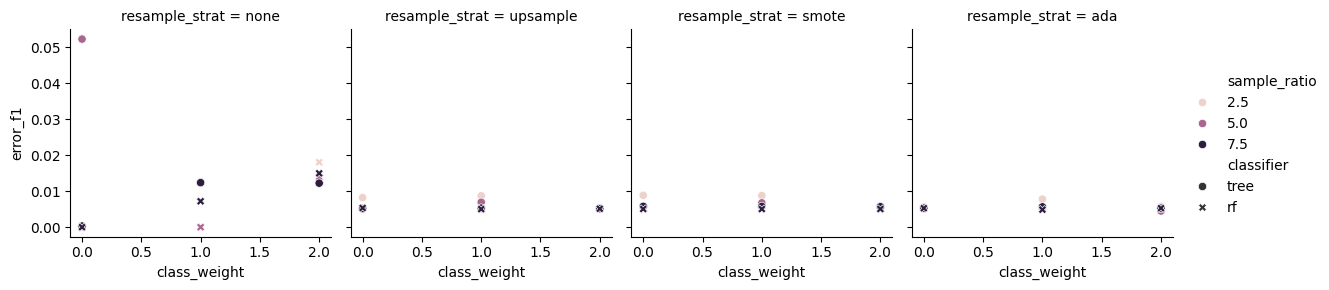

In [84]:
g=sns.FacetGrid(data=score_df, col='resample_strat')
g.map_dataframe(sns.scatterplot, x='class_weight', y='error_f1', hue='sample_ratio', style='classifier')
g.add_legend()
plt.show()